# Low-Rank Matrix Completion

**Published**: September 18, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/LRMC.ipynb).

--------------------

If you search `matrix completion` as a keyword on [**wiki**](https://en.wikipedia.org/wiki/Matrix_completion), you might see the following explaination for this concept:

> Matrix completion is the task of filling in the missing entries of a partially observed matrix. A wide range of datasets are naturally organized in matrix form.

From this brief explaination, we could on the one hand see that the matrix completion task requires us to use a mainfold of approaches to impute the missing values for a given matrix which is partially observed. On the other hand, it seems that there are tremendous real-world datasets organized in matrix form, and this means that you have an access to solve real-world missing data problems using matrix completion techniques.

**About this chapter**: This chapter does not intend to give a thorough review of low-rank matrix completion, but rather to highlight the basic idea of low-rank matrix completion, and to provide an overview of the key matrix completion techniques that have been successfully used. We direct the interested reader to the more focused references that are provided throughout the chapter.


## Motivation: Low-rank matrix completion and recovery

The data incompleteness problem appears often in machine learning. If you want to fully understand the matrix completion, then the following applications may be helpful:

- Recommender systems
- Image inpainting

### Recommender systems

A strong motivation for the matrix completion in recommender systems comes from user ratings of some items like products, movies, or musics which are put into a matrix $\boldsymbol{X}\in\mathbb{R}^{m\times n}$. The entries $x_{ij},\forall i\in\left\{1,...,m\right\},j\in\left\{1,...,n\right\}$ of the matrix correspond to the $i$-th user's rating of item $j$.

**A simple example**: In Figure 1, the question is how to predict unobserved entries of the matrix according to the limited observations.

![user_ratings_on_movies](../images/user_ratings_on_movies.png)
> Figure 1: User ratings of some movies are naturally organized in matrix form, where the matrix has some unobserved entries (i.e., unseen user ratings). Note that this figure is from http://www.princeton.edu/~yc5/ele538b_sparsity/lectures/matrix_recovery.pdf.


### Image inpainting

According to the definition on [**wiki**](https://en.wikipedia.org/wiki/Inpainting), inpainting is the process of reconstructing lost or deteriorated parts of images and videos. 

![lena](../images/lena.bmp)
> Figure 2: An image from https://raw.githubusercontent.com/qbzhao/BCPF/master/TestImages/lena.bmp.


The shape of the image is (256, 256, 3).


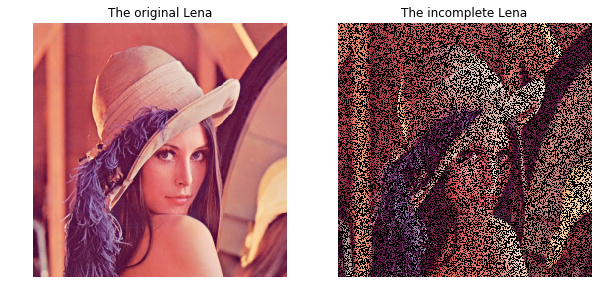

In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
mask = np.round(np.random.rand(dim1, dim2))  # Generate a binary mask.
for i in range(dim3):
    lena_in[:, :, i] = np.multiply(lena[:, :, i], mask)

plt.subplots(1, 2, figsize=(10,18))
plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

**Matrix completion problem description**: Suppose we observe partial entries of a matrix $\boldsymbol{Y}\in\mathbb{R}^{m\times n}$, indexed by the set $\Omega$. Then, the goal is to recover missing (or unobserved) entries in $\boldsymbol{Y}$.

It is not hard to understand the matrix completion problem if you see the following example:

> Suppose that we have a matrix like $\boldsymbol{Y}=\left[\begin{array}{ll}{2} & {\color{red}{?}} \\ {\color{red}{?}} & {4}\end{array}\right] \in \mathbb{R}^{2 \times 2}$, which is obviously a partially observed matrix. The observed entries of $\boldsymbol{Y}$ are indicated by the set $\Omega=\left\{\color{red}{(1,1),(2,2)}\right\}$. Then, applying the matrix completion technique, our final goal is to find a matrix like $\boldsymbol{X}=\left[\begin{array}{ll}{2} & {\color{red}{8}} \\ {\color{red}{1}} & {4}\end{array}\right] \in \mathbb{R}^{2 \times 2}$ that acts as the recovered matrix.


## Matrix completion for data without noise

To ease the reader's journey, there are two steps towards understanding the basic idea of the matrix completion techniques. The first is from the view of data noise. Indeed, the matrix completion for data without noise implies that the recovered matrix $\boldsymbol{X}$ has absolutely same entries on $\Omega$ as the original matrix $\boldsymbol{Y}$. It means that
$$\boldsymbol{X}_{\Omega}=\boldsymbol{Y}_{\Omega}.~~~~~~~~~~\text{(1)}$$

> For example, if we have a partially observed matrix $\boldsymbol{Y}\in\mathbb{R}^{2\times 2}$ like $$\boldsymbol{Y}=\left[\begin{array}{cc}y_{11} & \text{?} \\ \text{?} & y_{22} \\ \end{array}\right],$$ then, the recovered matrix $\boldsymbol{X}\in\mathbb{R}^{2\times 2}$ must satisfy $$\left\{\begin{array}{l}x_{11}=y_{11}, \\x_{22}=y_{22}. \\ \end{array}\right.$$

Then, the idea of the matrix completion is rank minimization. We assume that $\boldsymbol{X}$ is a low-rank matrix and write the matrix completion via rank minimization as
$$\begin{array}{ll} \min_{\boldsymbol{X}} & \text{rank}\left(\boldsymbol{X}\right)\\
\text{s.t.} & \boldsymbol{X}_{\Omega}=\boldsymbol{Y}_{\Omega}. \\ \end{array}~~~~~~~~~~\text{(2)}$$


## Noisy matrix completion